In [1]:
library(dada2)
library(ShortRead)

Loading required package: Rcpp
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, lengths, Map, mapply, match,
    mget, order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rowMeans, rownames, rowSums, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which, which.max, which.min

Loading required package: BiocParallel
Loading required

# Data prep: pool raw reads together
Sequencing was done on 4 different lanes


In [606]:
library(ShortRead)
library(stringr)
root <- '/mnt/chen-nas/SequenceData/Evan/122018_AP1_BFO_kSeq/raw.reads'

for (expRep in c('A', 'B')){
    for (concen in c('input', '0', '2', '10', '50', '250', '1250')){
        for (seqRep in c('A', 'B')){
            for (direction in c('1', '2')){
                regex <- paste('R[4F]', expRep, '-', concen, seqRep, '_S[[:digit:]]{1,2}_L00[1234]_R', direction, sep = '')
                print(sprintf('Research Regex (%s), %i file found.', regex, length(list.files(path = root, pattern = regex))))
                seqs <- readFastq(dirPath = root, pattern = regex)
                writeFastq(object = seqs, file = paste('/mnt/storage/projects/k-seq/input/bfo_counts/raw_reads_pooled/R4', expRep, '-', concen, seqRep, str_extract(pattern = '_S[[:digit:]]{1,2}_', string = list.files(path = root, pattern = regex)[1]), 'R', direction, '.fastq', sep = ''), compress = FALSE)
            }
        }
    }
} 

[1] "Research Regex (R[4F]A-inputA_S[[:digit:]]{1,2}_L00[1234]_R1), 4 file found."
[1] "Research Regex (R[4F]A-inputA_S[[:digit:]]{1,2}_L00[1234]_R2), 4 file found."
[1] "Research Regex (R[4F]A-inputB_S[[:digit:]]{1,2}_L00[1234]_R1), 4 file found."
[1] "Research Regex (R[4F]A-inputB_S[[:digit:]]{1,2}_L00[1234]_R2), 4 file found."
[1] "Research Regex (R[4F]A-0A_S[[:digit:]]{1,2}_L00[1234]_R1), 4 file found."
[1] "Research Regex (R[4F]A-0A_S[[:digit:]]{1,2}_L00[1234]_R2), 4 file found."
[1] "Research Regex (R[4F]A-0B_S[[:digit:]]{1,2}_L00[1234]_R1), 4 file found."
[1] "Research Regex (R[4F]A-0B_S[[:digit:]]{1,2}_L00[1234]_R2), 4 file found."
[1] "Research Regex (R[4F]A-2A_S[[:digit:]]{1,2}_L00[1234]_R1), 4 file found."
[1] "Research Regex (R[4F]A-2A_S[[:digit:]]{1,2}_L00[1234]_R2), 4 file found."
[1] "Research Regex (R[4F]A-2B_S[[:digit:]]{1,2}_L00[1234]_R1), 4 file found."
[1] "Research Regex (R[4F]A-2B_S[[:digit:]]{1,2}_L00[1234]_R2), 4 file found."
[1] "Research Regex (R[4F]A-10A_S[[:

In [9]:
seqs <- readFastq(dirPath = '/mnt/storage/projects/k-seq/input/bfo_counts/raw_reads_pooled/R4A-inputA_S1_R2.fastq')

In [10]:
readLengths <- width(seqs)
print(length(readLengths))
print(length(seqs))
summary(readLengths)

[1] 3061638
[1] 3061638


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
     35      76      76      76      76      76 

# Apply dada2 from raw data
why from raw sequencing data instead of trimmed data?
- we previously found the denoising in dada2 seems too aggresive, and further reading showed that dada2 allows end-free alignment, which means there are no penalty for end shift. This should be less problematic is we include the entire read, which flanking primers
## examine the data quality

In [2]:
readF <- sort(list.files(path = '/mnt/storage/projects/k-seq/input/bfo_counts/raw_reads_pooled/', pattern = "R1.fastq", full.names = TRUE))
readR <- sort(list.files(path = '/mnt/storage/projects/k-seq/input/bfo_counts/raw_reads_pooled/', pattern = "R2.fastq", full.names = TRUE))
sample.names <- sapply(strsplit(basename(readF), "_"), `[`, 1)

In [659]:
qPlotF <- plotQualityProfile(readF)
qPlotR <- plotQualityProfile(readR)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.


## Filter unqualified sequence
[filterAndTrim function kept reporting "C stack usage" error, I believe it is accociate with R/C/package installation. Will try with]
Mandatory:
  - dada2 can not handle sequences with ambiguous nucleotides N, need to removed
Additional:
  - min length of reads: seems most of reads are >70, lets trimmed of reads shorter than 65
  - min quality: quality of the reads are very consistent, we could pass some low quality reads as dada2 claims to be able to handle low quality reads, keep it default as 2
  - length trimming: no significant drop of quality found at the end of the reads, no trimming
  - rm.phix: yes, it might be already removed 
  - Rev: yes as it is paired-end reads

In [3]:
filtFs <- file.path('/mnt/storage/projects/k-seq/working/dada2_raw/', 'filtered', paste0(sample.names, "_F_filt.fastq.gz"))
filtRs <- file.path('/mnt/storage/projects/k-seq/working/dada2_raw/', 'filtered', paste0(sample.names, "_R_filt.fastq.gz"))

In [6]:
filterRes <- filterAndTrim(readF, filtFs, readR, filtRs, maxN = 0, minLen = 65, rm.phix = TRUE, compress = TRUE, multithread = TRUE)

Warning message in mclapply(seq_len(n), do_one, mc.preschedule = mc.preschedule, :
“all scheduled cores encountered errors in user code”

ERROR: Error in filterAndTrim(readF, filtFs, readR, filtRs, maxN = 0, minLen = 65, : These are the errors (up to 5) encountered in individual cores...
Error : C stack usage  7969844 is too close to the limit
Error : C stack usage  7969844 is too close to the limit
Error : C stack usage  7969844 is too close to the limit
Error : C stack usage  7969844 is too close to the limit
Error : C stack usage  7969844 is too close to the limit



## Error rate learning

In [26]:
filteredFs <- list.files('/mnt/storage/projects/k-seq/working/dada2_raw/filtered_testSamples/', pattern = 'R1_filtered_ordered', full.names = TRUE)
filteredRs <- list.files('/mnt/storage/projects/k-seq/working/dada2_raw/filtered_testSamples/', pattern = 'R2_filtered_ordered', full.names = TRUE)
sample.names <- sapply(strsplit(basename(filteredFs), "_"), `[`, 1)

In [28]:
errF <- learnErrors(filteredFs, multithread = TRUE, randomize = TRUE)
errR <- learnErrors(filteredRs, multithread = TRUE, randomize = TRUE)
save(errF, errR, file = '/mnt/storage/projects/k-seq/working/dada2_raw/filtered_testSamples/err_estimated.RData')

115266618 total bases in 1748656 reads from 1 samples will be used for learning the error rates.
201813394 total bases in 2655496 reads from 1 samples will be used for learning the error rates.


Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”

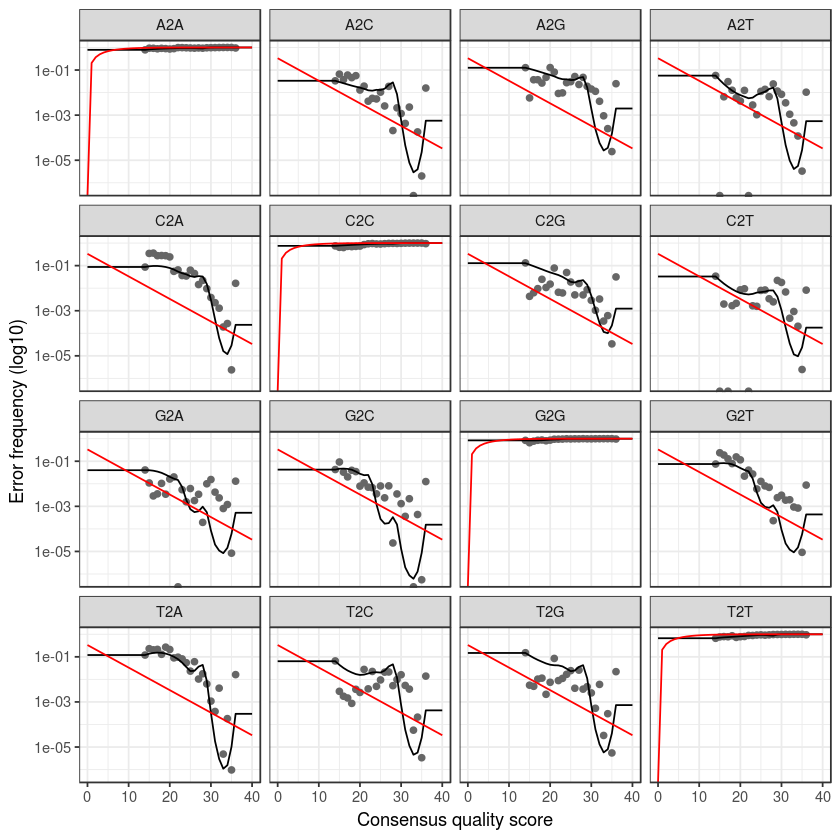

In [30]:
plotErrors(errR, nominalQ = TRUE)

In [31]:
derepFs <- derepFastq(filteredFs, verbose = TRUE)
names(derepFs) <- sapply(strsplit(basename(filteredFs), "_"), `[`, 1)

Dereplicating sequence entries in Fastq file: /mnt/storage/projects/k-seq/working/dada2_raw/filtered_testSamples//R4A-inputA_S1_R1_filtered_ordered.fastq
...Encountered 502842 unique sequences from 3044436 total sequences read.
Dereplicating sequence entries in Fastq file: /mnt/storage/projects/k-seq/working/dada2_raw/filtered_testSamples//R4A-inputB_S8_R1_filtered_ordered.fastq
.Encountered 264845 unique sequences from 1748656 total sequences read.
Dereplicating sequence entries in Fastq file: /mnt/storage/projects/k-seq/working/dada2_raw/filtered_testSamples//R4B-inputA_S15_R1_filtered_ordered.fastq
..Encountered 542953 unique sequences from 2655496 total sequences read.
Dereplicating sequence entries in Fastq file: /mnt/storage/projects/k-seq/working/dada2_raw/filtered_testSamples//R4B-inputB_S22_R1_filtered_ordered.fastq
..Encountered 546732 unique sequences from 2441020 total sequences read.


In [32]:
derepRs <- derepFastq(filteredRs, verbose = TRUE)
names(derepRs) <- sapply(strsplit(basename(filteredRs), "_"), `[`, 1)

Dereplicating sequence entries in Fastq file: /mnt/storage/projects/k-seq/working/dada2_raw/filtered_testSamples//R4A-inputA_S1_R2_filtered_ordered.fastq
...Encountered 540408 unique sequences from 3044436 total sequences read.
Dereplicating sequence entries in Fastq file: /mnt/storage/projects/k-seq/working/dada2_raw/filtered_testSamples//R4A-inputB_S8_R2_filtered_ordered.fastq
.Encountered 287941 unique sequences from 1748656 total sequences read.
Dereplicating sequence entries in Fastq file: /mnt/storage/projects/k-seq/working/dada2_raw/filtered_testSamples//R4B-inputA_S15_R2_filtered_ordered.fastq
..Encountered 575858 unique sequences from 2655496 total sequences read.
Dereplicating sequence entries in Fastq file: /mnt/storage/projects/k-seq/working/dada2_raw/filtered_testSamples//R4B-inputB_S22_R2_filtered_ordered.fastq
..Encountered 573417 unique sequences from 2441020 total sequences read.


## dada2 denoising

In [33]:
dadaF <- dada(derep = derepFs, err = errF, multithread = TRUE)

Sample 1 - 3044436 reads in 502842 unique sequences.
Sample 2 - 1748656 reads in 264845 unique sequences.
Sample 3 - 2655496 reads in 542953 unique sequences.
Sample 4 - 2441020 reads in 546732 unique sequences.


In [34]:
dadaR <- dada(derep = derepRs, err = errR, multithread = TRUE)

Sample 1 - 3044436 reads in 540408 unique sequences.
Sample 2 - 1748656 reads in 287941 unique sequences.
Sample 3 - 2655496 reads in 575858 unique sequences.
Sample 4 - 2441020 reads in 573417 unique sequences.


In [35]:
save(derepFs, derepRs, file = '/mnt/storage/projects/k-seq/working/dada2_raw/filtered_testSamples/derepReads.RData')
save(dadaF, dadaR, file = '/mnt/storage/projects/k-seq/working/dada2_raw/filtered_testSamples/denoisedRes.RData')

## Merge reads

In [37]:
mergers <- mergePairs(dadaF = dadaF, derepF = derepFs, dadaR = dadaR, derepR = derepRs, verbose = TRUE)

2523133 paired-reads (in 139 unique pairings) successfully merged out of 3033529 (in 14849 pairings) input.
1493588 paired-reads (in 102 unique pairings) successfully merged out of 1741403 (in 8009 pairings) input.
2145697 paired-reads (in 145 unique pairings) successfully merged out of 2644150 (in 12411 pairings) input.
1920882 paired-reads (in 138 unique pairings) successfully merged out of 2431911 (in 14394 pairings) input.


In [49]:
mergers[[4]]$sequence

[1] "ATACGACTCACTATAGGGAATGGATCCACATCTACGAATTCCTACTTCAAACAATCGGTCTGTTCACTGCAGACTTGACGAAGCTG" 
  [2] "ATACGACTCACTATAGGGAATGGATCCACATCTACGAATTCAAAAACAAAAACAAAAACAAATTCACTGCAGACTTGACGAAGCTG" 
  [3] "ATACGACTCACTATAGGGAATGGATCCACATCTACGAATTCATTACCCTGGTCATCGAGTGATTCACTGCAGACTTGACGAAGCTG" 
  [4] "ATACGACTCACTATAGGGAATGGATCCACATCTACGAATTCATTACCCTGGTCATCGAGTGTTTCACTGCAGACTTGACGAAGCTG" 
  [5] "ATACGACTCACTATAGGGAATGGATCCACATCTACGAATTCCCACACTTCAAGCAATCGGTCTTCACTGCAGACTTGACGAAGCTG" 
  [6] "ATACGACTCACTATAGGGAATGGATCCACATCTACGAATTCATTCACCTAGGTCATCGGGTGTTTCACTGCAGACTTGACGAAGCTG"
  [7] "ATACGACTCACTATAGGGAATGGATCCACATCTACGAATTCCTCTTCAAACAATCGGTCTTCTTCACTGCAGACTTGACGAAGCTG" 
  [8] "ATACGACTCACTATAGGGAATGGATCCACATCTACGAATTCCCGCTTCAAACAATCGGTTTGTTCACTGCAGACTTGACGAAGCTG" 
  [9] "ATACGACTCACTATAGGGAATGGATCCACATCTACGAATTCACCCACTTCAAACAATCGGTCTTCACTGCAGACTTGACGAAGCTG" 
 [10] "ATACGACTCACTATAGGGAATGGATCCACATCTACGAATTCATTCACCTAGGTCATCGAGTGTTTCACTGCAGACTTGACGAAGCTG"
 [11] "ATACGACTCACTATAGGGAATGGATCCACATCTACGAATTCCTGCTTCAAACAATCGGTGTGTTCACTGCAGACTTGACGAAGCTG" 
 [12] "ATACGACTCACTATAGGGAATGGATCCACATCTACGAATTCATTCACCTAGGTCATCGAGTGATTCACTGCAGACTTGACGAAGCTG"
 [13] "ATACGACTCACTATAGGGAATGGATCCACATCTACGAATTCCCGCTTCAAGCAATCGGTCGCTTCACTGCAGACTTGACGAAGCTG" 
 [14] "ATACGACTCACTATAGGGAATGGATCCACATCTACGAATTCATCCTGCTTCAACCAATCGGTTTCACTGCAGACTTGACGAAGCTG" 
 [15] "ATACGACTCACTATAGGGAATGGATCCACATCTACGAATTCAAGTTTGCTAATAGTCGCAAGTTCACTGCAGACTTGACGAAGCTG" 
 [16] "ATACGACTCACTATAGGGAATGGATCCACATCTACGAATTCGTTCAGTTTCAAGCAATCGGTTTCACTGCAGACTTGACGAAGCTG" 
 [17] "ATACGACTCACTATAGGGAATGGATCCACATCTACGAATTCATTGCCCTGGTCATCGAGTGTTTCACTGCAGACTTGACGAAGCTG" 
 [18] "ATACGACTCACTATAGGGAATGGATCCACATCTACGAATTCCTGTTTCAAACAATCGGCCTGTTCACTGCAGACTTGACGAAGCTG" 
 [19] "ATACGACTCACTATAGGGAATGGATCCACATCTACGAATTCCTGTTTCAAACAATCGGTCTCTTCACTGCAGACTTGACGAAGCTG" 
 [20] "ATACGACTCACTATAGGGAATGGATCCACATCTACGAATTCCTCTTCAATAATCGGTTGCGTTTCACTGCAGACTTGACGAAGCTG" 
 [21] "ATACGACTCACTATAGGGAATGGATCCACATCTACGAATTCTCCTGTTTCAAGCAATCGGTCTTCACTGCAGACTTGACGAAGCTG" 
 [22] "ATACGACTCACTATAGGGAATGGATCCACATCTACGAATTCCCGAGTTTCAAGCAATCGGTCTTCACTGCAGACTTGACGAAGCTG" 
 [23] "ATACGACTCACTATAGGGAATGGATCCACATCTACGAATTCATGGCCCTGGTCATCGAGTGATTCACTGCAGACTTGACGAAGCTG" 
 [24] "ATACGACTCACTATAGGGAATGGATCCACATCTACGAATTCACCCGCTTCAACCAATCGGTCTTCACTGCAGACTTGACGAAGCTG" 
 [25] "ATACGACTCACTATAGGGAATGGATCCACATCTACGAATTCGTTACCCTGGTCATCGAGTGTTTCACTGCAGACTTGACGAAGCTG" 
 [26] "ATACGACTCACTATAGGGAATGGATCCACATCTACGAATTCATTATCCTGGTCATCGAGTGATTCACTGCAGACTTGACGAAGCTG" 
 [27] "ATACGACTCACTATAGGGAATGGATCCACATCTACGAATTCATCCAGTTTCAAGCAATCGGTTTCACTGCAGACTTGACGAAGCTG" 
 [28] "ATACGACTCACTATAGGGAATGGATCCACATCTACGAATTCGCTATATGTCGATGGGTATTCTTCACTGCAGACTTGACGAAGCTG" 
 [29] "ATACGACTCACTATAGGGAATGGATCCACATCTACGAATCCCTCTTCAAACAATCGGTCTTCTTCACTGCAGACTTGACGAAGCTG" 
 [30] "ATACGACTCACTATAGGGAATGGATCCACATCTACGAATTCATGACCCTGGTCATCGGGTGTTTCACTGCAGACTTGACGAAGCTG" 
 [31] "ATACGACTCACTATAGGGAATGGATCCACATCTACGAATTCCTGTTTCAAACAATCGGTCGCTTCACTGCAGACTTGACGAAGCTG" 
 [32] "ATACGACTCACTATAGGGAATGGATCCACATCTACGAATTCATTACCCTGGTCATTGAGTGTTTCACTGCAGACTTGACGAAGCTG" 
 [33] "ATACGACTCACTATAGGGAATGGATCCACATCTACGAATTCCCAAACTTCAAACAATCGGTCTTCACTGCAGACTTGACGAAGCTG" 
 [34] "ATACGACTCACTATAGGGAATGGATCCACATCTACGAATTCCTCTACTTCAAGCAATCGGTCTTCACTGCAGACTTGACGAAGCTG" 
 [35] "ATACGACTCACTATAGGGAATGGATCCACATCTACGAATTCCCGCTTCAAACAATCGGTGTGCTTCACTGCAGACTTGACGAAGCTG"
 [36] "ATACGACTCACTATAGGGAATGGATCCACATCTACGAATTCTTTACCCTGGTCATCGAGTGTTTCACTGCAGACTTGACGAAGCTG" 
 [37] "ATACGACTCACTATAGGGAATGGATCCACATCTACGAATTCTCGCCCTTCAAACAATCGGTCTTCACTGCAGACTTGACGAAGCTG" 
 [38] "ATACGACTCACTATAGGGAATGGATCCACATCTACGAATTCCCACACTTCAACCAATCGGTCTTCACTGCAGACTTGACGAAGCTG" 
 [39] "ATACGACTCACTATAGGGAATGGATCCACATCTACGAATTCCTACTTCAAACAATCGGCCTGTTCACTGCAGACTTGACGAAGCTG" 
 [40] "ATACGACTCACTATAGGGAATGGATCCACATCTACGAATTCATTCACCTAGGTCATCGGGTATTCACTGCAGACTTGACGAAGCTG" 
 [41] "ATACGACTCACTATAGGGAATGGATCCACATCTACGAATTCATTGCCCTGGTCATCGAGTGATTCACTGCAGACTTGACGAAGCTG" 
 [42] "ATACGACTCACTATAGGGAATGGATCCACATCTACGAATTCTCGCTTCAAACAATCGGT

# test with default error reported from Phred

In [187]:
length(dircList)

[1] 28

In [504]:
dircList <- c(
 '/mnt/storage/projects/k-seq/working/dada2/strict_21/R4A-inputA_S1.joined.filtered.fastq',
 '/mnt/storage/projects/k-seq/working/dada2/strict_21/RFA-1250A_S2.joined.filtered.fastq',
 '/mnt/storage/projects/k-seq/working/dada2/strict_21/R4A-250A_S3.joined.filtered.fastq',
 '/mnt/storage/projects/k-seq/working/dada2/strict_21/R4A-50A_S4.joined.filtered.fastq',
 '/mnt/storage/projects/k-seq/working/dada2/strict_21/R4A-10A_S5.joined.filtered.fastq',
 '/mnt/storage/projects/k-seq/working/dada2/strict_21/R4A-2A_S6.joined.filtered.fastq',
 '/mnt/storage/projects/k-seq/working/dada2/strict_21/R4A-0A_S7.joined.filtered.fastq',
 '/mnt/storage/projects/k-seq/working/dada2/strict_21/R4A-inputB_S8.joined.filtered.fastq',
 '/mnt/storage/projects/k-seq/working/dada2/strict_21/RFA-1250B_S9.joined.filtered.fastq',
 '/mnt/storage/projects/k-seq/working/dada2/strict_21/R4A-250B_S10.joined.filtered.fastq',
 '/mnt/storage/projects/k-seq/working/dada2/strict_21/R4A-50B_S11.joined.filtered.fastq',
 '/mnt/storage/projects/k-seq/working/dada2/strict_21/R4A-10B_S12.joined.filtered.fastq',
 '/mnt/storage/projects/k-seq/working/dada2/strict_21/R4A-2B_S13.joined.filtered.fastq',
 '/mnt/storage/projects/k-seq/working/dada2/strict_21/R4A-0B_S14.joined.filtered.fastq',
 '/mnt/storage/projects/k-seq/working/dada2/strict_21/R4B-inputA_S15.joined.filtered.fastq',
 '/mnt/storage/projects/k-seq/working/dada2/strict_21/RFB-1250A_S16.joined.filtered.fastq',
 '/mnt/storage/projects/k-seq/working/dada2/strict_21/R4B-250A_S17.joined.filtered.fastq',
 '/mnt/storage/projects/k-seq/working/dada2/strict_21/R4B-50A_S18.joined.filtered.fastq',
 '/mnt/storage/projects/k-seq/working/dada2/strict_21/R4B-10A_S19.joined.filtered.fastq',
 '/mnt/storage/projects/k-seq/working/dada2/strict_21/R4B-2A_S20.joined.filtered.fastq',
 '/mnt/storage/projects/k-seq/working/dada2/strict_21/R4B-0A_S21.joined.filtered.fastq',
 '/mnt/storage/projects/k-seq/working/dada2/strict_21/R4B-inputB_S22.joined.filtered.fastq',
 '/mnt/storage/projects/k-seq/working/dada2/strict_21/RFB-1250B_S23.joined.filtered.fastq',
 '/mnt/storage/projects/k-seq/working/dada2/strict_21/R4B-250B_S24.joined.filtered.fastq',
 '/mnt/storage/projects/k-seq/working/dada2/strict_21/R4B-50B_S25.joined.filtered.fastq',
 '/mnt/storage/projects/k-seq/working/dada2/strict_21/R4B-10B_S26.joined.filtered.fastq',
 '/mnt/storage/projects/k-seq/working/dada2/strict_21/R4B-2B_S27.joined.filtered.fastq',
 '/mnt/storage/projects/k-seq/working/dada2/strict_21/R4B-0B_S28.joined.filtered.fastq')

dadaRes <- list()

for (i in 1:length(dircList)){
  # err <- learnErrors(dircList[i], multithread = TRUE)
   derep <- derepFastq(dircList[i], verbose = TRUE)
   denoised <- dada(derep, err = defaultErr, multithread = TRUE)
   currentRes = list(dirc=dircList[i], err=err, derep=derep, denoised=denoised) 
   dadaRes[[i]] <- currentRes
}

Dereplicating sequence entries in Fastq file: /mnt/storage/projects/k-seq/working/dada2/strict_21/R4A-inputA_S1.joined.filtered.fastq
.Encountered 312944 unique sequences from 1972625 total sequences read.
Warning message in getErrors(err, enforce = TRUE):
“Zero in error matrix.”

Sample 1 - 1972625 reads in 312944 unique sequences.


Dereplicating sequence entries in Fastq file: /mnt/storage/projects/k-seq/working/dada2/strict_21/RFA-1250A_S2.joined.filtered.fastq
.Encountered 26811 unique sequences from 1887026 total sequences read.
Warning message in getErrors(err, enforce = TRUE):
“Zero in error matrix.”

Sample 1 - 1887026 reads in 26811 unique sequences.


Dereplicating sequence entries in Fastq file: /mnt/storage/projects/k-seq/working/dada2/strict_21/R4A-250A_S3.joined.filtered.fastq
.Encountered 21701 unique sequences from 1721820 total sequences read.
Warning message in getErrors(err, enforce = TRUE):
“Zero in error matrix.”

Sample 1 - 1721820 reads in 21701 unique sequences.


Dereplicating sequence entries in Fastq file: /mnt/storage/projects/k-seq/working/dada2/strict_21/R4A-50A_S4.joined.filtered.fastq
..Encountered 40200 unique sequences from 2407377 total sequences read.
Warning message in getErrors(err, enforce = TRUE):
“Zero in error matrix.”

Sample 1 - 2407377 reads in 40200 unique sequences.


Dereplicating sequence entries in Fastq file: /mnt/storage/projects/k-seq/working/dada2/strict_21/R4A-10A_S5.joined.filtered.fastq
.Encountered 24080 unique sequences from 1392173 total sequences read.
Warning message in getErrors(err, enforce = TRUE):
“Zero in error matrix.”

Sample 1 - 1392173 reads in 24080 unique sequences.


Dereplicating sequence entries in Fastq file: /mnt/storage/projects/k-seq/working/dada2/strict_21/R4A-2A_S6.joined.filtered.fastq
.Encountered 21992 unique sequences from 1449941 total sequences read.
Warning message in getErrors(err, enforce = TRUE):
“Zero in error matrix.”

Sample 1 - 1449941 reads in 21992 unique sequences.


Dereplicating sequence entries in Fastq file: /mnt/storage/projects/k-seq/working/dada2/strict_21/R4A-0A_S7.joined.filtered.fastq
..Encountered 1348 unique sequences from 2782840 total sequences read.
Warning message in getErrors(err, enforce = TRUE):
“Zero in error matrix.”

Sample 1 - 2782840 reads in 1348 unique sequences.


Dereplicating sequence entries in Fastq file: /mnt/storage/projects/k-seq/working/dada2/strict_21/R4A-inputB_S8.joined.filtered.fastq
.Encountered 164497 unique sequences from 1163240 total sequences read.
Warning message in getErrors(err, enforce = TRUE):
“Zero in error matrix.”

Sample 1 - 1163240 reads in 164497 unique sequences.


Dereplicating sequence entries in Fastq file: /mnt/storage/projects/k-seq/working/dada2/strict_21/RFA-1250B_S9.joined.filtered.fastq
...Encountered 39007 unique sequences from 3261229 total sequences read.
Warning message in getErrors(err, enforce = TRUE):
“Zero in error matrix.”

Sample 1 - 3261229 reads in 39007 unique sequences.


Dereplicating sequence entries in Fastq file: /mnt/storage/projects/k-seq/working/dada2/strict_21/R4A-250B_S10.joined.filtered.fastq
.........Encountered 112119 unique sequences from 9651905 total sequences read.
Warning message in getErrors(err, enforce = TRUE):
“Zero in error matrix.”

Sample 1 - 9651905 reads in 112119 unique sequences.


Dereplicating sequence entries in Fastq file: /mnt/storage/projects/k-seq/working/dada2/strict_21/R4A-50B_S11.joined.filtered.fastq
..Encountered 52717 unique sequences from 2324796 total sequences read.
Warning message in getErrors(err, enforce = TRUE):
“Zero in error matrix.”

Sample 1 - 2324796 reads in 52717 unique sequences.


Dereplicating sequence entries in Fastq file: /mnt/storage/projects/k-seq/working/dada2/strict_21/R4A-10B_S12.joined.filtered.fastq
..Encountered 61434 unique sequences from 2182334 total sequences read.
Warning message in getErrors(err, enforce = TRUE):
“Zero in error matrix.”

Sample 1 - 2182334 reads in 61434 unique sequences.


Dereplicating sequence entries in Fastq file: /mnt/storage/projects/k-seq/working/dada2/strict_21/R4A-2B_S13.joined.filtered.fastq
.Encountered 38021 unique sequences from 1750328 total sequences read.
Warning message in getErrors(err, enforce = TRUE):
“Zero in error matrix.”

Sample 1 - 1750328 reads in 38021 unique sequences.


Dereplicating sequence entries in Fastq file: /mnt/storage/projects/k-seq/working/dada2/strict_21/R4A-0B_S14.joined.filtered.fastq
..Encountered 944 unique sequences from 2408620 total sequences read.
Warning message in getErrors(err, enforce = TRUE):
“Zero in error matrix.”

Sample 1 - 2408620 reads in 944 unique sequences.


Dereplicating sequence entries in Fastq file: /mnt/storage/projects/k-seq/working/dada2/strict_21/R4B-inputA_S15.joined.filtered.fastq
..Encountered 467838 unique sequences from 2325271 total sequences read.
Warning message in getErrors(err, enforce = TRUE):
“Zero in error matrix.”

Sample 1 - 2325271 reads in 467838 unique sequences.


Dereplicating sequence entries in Fastq file: /mnt/storage/projects/k-seq/working/dada2/strict_21/RFB-1250A_S16.joined.filtered.fastq
.Encountered 24909 unique sequences from 1510053 total sequences read.
Warning message in getErrors(err, enforce = TRUE):
“Zero in error matrix.”

Sample 1 - 1510053 reads in 24909 unique sequences.


Dereplicating sequence entries in Fastq file: /mnt/storage/projects/k-seq/working/dada2/strict_21/R4B-250A_S17.joined.filtered.fastq
..Encountered 40032 unique sequences from 2958593 total sequences read.
Warning message in getErrors(err, enforce = TRUE):
“Zero in error matrix.”

Sample 1 - 2958593 reads in 40032 unique sequences.


Dereplicating sequence entries in Fastq file: /mnt/storage/projects/k-seq/working/dada2/strict_21/R4B-50A_S18.joined.filtered.fastq
...Encountered 62801 unique sequences from 3322675 total sequences read.
Warning message in getErrors(err, enforce = TRUE):
“Zero in error matrix.”

Sample 1 - 3322675 reads in 62801 unique sequences.


Dereplicating sequence entries in Fastq file: /mnt/storage/projects/k-seq/working/dada2/strict_21/R4B-10A_S19.joined.filtered.fastq
...Encountered 62775 unique sequences from 3450131 total sequences read.
Warning message in getErrors(err, enforce = TRUE):
“Zero in error matrix.”

Sample 1 - 3450131 reads in 62775 unique sequences.


Dereplicating sequence entries in Fastq file: /mnt/storage/projects/k-seq/working/dada2/strict_21/R4B-2A_S20.joined.filtered.fastq
..Encountered 27540 unique sequences from 2335473 total sequences read.
Warning message in getErrors(err, enforce = TRUE):
“Zero in error matrix.”

Sample 1 - 2335473 reads in 27540 unique sequences.


Dereplicating sequence entries in Fastq file: /mnt/storage/projects/k-seq/working/dada2/strict_21/R4B-0A_S21.joined.filtered.fastq
.Encountered 664 unique sequences from 1855534 total sequences read.
Warning message in getErrors(err, enforce = TRUE):
“Zero in error matrix.”

Sample 1 - 1855534 reads in 664 unique sequences.


Dereplicating sequence entries in Fastq file: /mnt/storage/projects/k-seq/working/dada2/strict_21/R4B-inputB_S22.joined.filtered.fastq
..Encountered 472800 unique sequences from 2110243 total sequences read.
Warning message in getErrors(err, enforce = TRUE):
“Zero in error matrix.”

Sample 1 - 2110243 reads in 472800 unique sequences.


Dereplicating sequence entries in Fastq file: /mnt/storage/projects/k-seq/working/dada2/strict_21/RFB-1250B_S23.joined.filtered.fastq
..Encountered 43500 unique sequences from 2899869 total sequences read.
Warning message in getErrors(err, enforce = TRUE):
“Zero in error matrix.”

Sample 1 - 2899869 reads in 43500 unique sequences.


Dereplicating sequence entries in Fastq file: /mnt/storage/projects/k-seq/working/dada2/strict_21/R4B-250B_S24.joined.filtered.fastq
...Encountered 33990 unique sequences from 3010679 total sequences read.
Warning message in getErrors(err, enforce = TRUE):
“Zero in error matrix.”

Sample 1 - 3010679 reads in 33990 unique sequences.


Dereplicating sequence entries in Fastq file: /mnt/storage/projects/k-seq/working/dada2/strict_21/R4B-50B_S25.joined.filtered.fastq
..Encountered 50089 unique sequences from 2610268 total sequences read.
Warning message in getErrors(err, enforce = TRUE):
“Zero in error matrix.”

Sample 1 - 2610268 reads in 50089 unique sequences.


Dereplicating sequence entries in Fastq file: /mnt/storage/projects/k-seq/working/dada2/strict_21/R4B-10B_S26.joined.filtered.fastq
.Encountered 35597 unique sequences from 1908811 total sequences read.
Warning message in getErrors(err, enforce = TRUE):
“Zero in error matrix.”

Sample 1 - 1908811 reads in 35597 unique sequences.


Dereplicating sequence entries in Fastq file: /mnt/storage/projects/k-seq/working/dada2/strict_21/R4B-2B_S27.joined.filtered.fastq
..Encountered 38818 unique sequences from 2351197 total sequences read.
Warning message in getErrors(err, enforce = TRUE):
“Zero in error matrix.”

Sample 1 - 2351197 reads in 38818 unique sequences.


Dereplicating sequence entries in Fastq file: /mnt/storage/projects/k-seq/working/dada2/strict_21/R4B-0B_S28.joined.filtered.fastq
..Encountered 17521 unique sequences from 2078977 total sequences read.
Warning message in getErrors(err, enforce = TRUE):
“Zero in error matrix.”

Sample 1 - 2078977 reads in 17521 unique sequences.


In [505]:
for (res in dadaRes){
    print(length(res$denoised$denoised))
}

[1] 40
[1] 36
[1] 31
[1] 36
[1] 34
[1] 36
[1] 23
[1] 31
[1] 39
[1] 48
[1] 38
[1] 37
[1] 41
[1] 21
[1] 51
[1] 33
[1] 38
[1] 38
[1] 44
[1] 40
[1] 17
[1] 44
[1] 38
[1] 36
[1] 35
[1] 38
[1] 41
[1] 36


In [497]:
get_seq_sample_info <- function(seqTest, sampleIx){
    seqCount <- dadaRes[[sampleIx]]$derep$unique[seqTest][[1]]
    centerSeq <- names(dadaRes[[sampleIx]]$denoised$denoised[dadaRes[[sampleIx]]$denoised$map[match(seqTest, names(dadaRes[[sampleIx]]$derep$unique))]])
    centerSeqCountOriginal <- dadaRes[[sampleIx]]$derep$unique[centerSeq][[1]]
    centerSeqCountAdjusted <- dadaRes[[sampleIx]]$denoised$denoised[centerSeq][[1]]
    returnList <- list(seqCount=seqCount, centerSeq=centerSeq, centerSeqCountOriginal=centerSeqCountOriginal, centerSeqCountAdjusted=centerSeqCountAdjusted)
    return(returnList)
}

for (i in 1:28){
    print(c(i, get_seq_sample_info('TTCACCTAGGTCATCGAGTGT', i)$centerSeq))
}


[1] "1"                     "TTCACCTAGGTCATCGAGTGT"
[1] "2"                     "TTCACCTAGGTCATCGAGTGT"
[1] "3"                     "TTCACCTAGGTCATCGAGTGT"
[1] "4"                     "TTCACCTAGGTCATCGAGTGT"
[1] "5"                     "TTCACCTAGGTCATCGAGTGT"
[1] "6"                     "TTCACCTAGGTCATCGAGTGT"
[1] "7"                     "ATTCACCTAGGTCATCGGGTG"
[1] "8"                     "TTCACCTAGGTCATCGAGTGT"
[1] "9"                     "TTCACCTAGGTCATCGAGTGT"
[1] "10"                    "TTCACCTAGGTCATCGAGTGT"
[1] "11"                    "TTCACCTAGGTCATCGAGTGT"
[1] "12"                    "TTCACCTAGGTCATCGAGTGT"
[1] "13"                    "TTCACCTAGGTCATCGAGTGT"
[1] "14"                    "ATTCACCTAGGTCATCGGGTG"
[1] "15"                    "TTCACCTAGGTCATCGAGTGT"
[1] "16"                    "TTCACCTAGGTCATCGAGTGT"
[1] "17"                    "TTCACCTAGGTCATCGAGTGT"
[1] "18"                    "TTCACCTAGGTCATCGAGTGT"
[1] "19"                    "TTCACCTAGGTCATCGAGTGT"
[1] "20"    

In [496]:
adist('TTCCTGCTTCAAGCAATCGGT', 'CCGCTTCAAGCAATCGGTCGC', counts = TRUE)

6


In [502]:
generate_defaultErr <- function(){
    defaultErr <- err$err_out
    for (i in 1:16){
        for (j in 0:40){
            p <- 10**(-j/10)
            if (i %in% c(1, 6, 11, 16)){
                defaultErr[i, j+1] <- 1-p
            } else{
                defaultErr[i, j+1] <- p/3
            }
        }
    }
    return(defaultErr)
}
defaultErr <- generate_defaultErr()

In [503]:
defaultErr

,0,1,2,3,4,5,6,7,8,9,⋯,31,32,33,34,35,36,37,38,39,40
A2A,0.0000000,0.2056718,0.3690427,0.4988128,0.6018928,0.6837722,0.74881136,0.80047377,0.84151068,0.87410746,⋯,0.9992056718,0.9993690427,0.9994988128,0.9996018928,0.9996837722,9.997488e-01,9.998005e-01,9.998415e-01,9.998741e-01,9.999000e-01
A2C,0.3333333,0.2647761,0.2103191,0.1670624,0.1327024,0.1054093,0.08372955,0.06650874,0.05282977,0.04196418,⋯,0.0002647761,0.0002103191,0.0001670624,0.0001327024,0.0001054093,8.372955e-05,6.650874e-05,5.282977e-05,4.196418e-05,3.333333e-05
A2G,0.3333333,0.2647761,0.2103191,0.1670624,0.1327024,0.1054093,0.08372955,0.06650874,0.05282977,0.04196418,⋯,0.0002647761,0.0002103191,0.0001670624,0.0001327024,0.0001054093,8.372955e-05,6.650874e-05,5.282977e-05,4.196418e-05,3.333333e-05
A2T,0.3333333,0.2647761,0.2103191,0.1670624,0.1327024,0.1054093,0.08372955,0.06650874,0.05282977,0.04196418,⋯,0.0002647761,0.0002103191,0.0001670624,0.0001327024,0.0001054093,8.372955e-05,6.650874e-05,5.282977e-05,4.196418e-05,3.333333e-05
C2A,0.3333333,0.2647761,0.2103191,0.1670624,0.1327024,0.1054093,0.08372955,0.06650874,0.05282977,0.04196418,⋯,0.0002647761,0.0002103191,0.0001670624,0.0001327024,0.0001054093,8.372955e-05,6.650874e-05,5.282977e-05,4.196418e-05,3.333333e-05
C2C,0.0000000,0.2056718,0.3690427,0.4988128,0.6018928,0.6837722,0.74881136,0.80047377,0.84151068,0.87410746,⋯,0.9992056718,0.9993690427,0.9994988128,0.9996018928,0.9996837722,9.997488e-01,9.998005e-01,9.998415e-01,9.998741e-01,9.999000e-01
C2G,0.3333333,0.2647761,0.2103191,0.1670624,0.1327024,0.1054093,0.08372955,0.06650874,0.05282977,0.04196418,⋯,0.0002647761,0.0002103191,0.0001670624,0.0001327024,0.0001054093,8.372955e-05,6.650874e-05,5.282977e-05,4.196418e-05,3.333333e-05
C2T,0.3333333,0.2647761,0.2103191,0.1670624,0.1327024,0.1054093,0.08372955,0.06650874,0.05282977,0.04196418,⋯,0.0002647761,0.0002103191,0.0001670624,0.0001327024,0.0001054093,8.372955e-05,6.650874e-05,5.282977e-05,4.196418e-05,3.333333e-05
G2A,0.3333333,0.2647761,0.2103191,0.1670624,0.1327024,0.1054093,0.08372955,0.06650874,0.05282977,0.04196418,⋯,0.0002647761,0.0002103191,0.0001670624,0.0001327024,0.0001054093,8.372955e-05,6.650874e-05,5.282977e-05,4.196418e-05,3.333333e-05
G2C,0.3333333,0.2647761,0.2103191,0.1670624,0.1327024,0.1054093,0.08372955,0.06650874,0.05282977,0.04196418,⋯,0.0002647761,0.0002103191,0.0001670624,0.0001327024,0.0001054093,8.372955e-05,6.650874e-05,5.282977e-05,4.196418e-05,3.333333e-05


In [107]:
testSeqs <- c('TTCACCTAGGTCATCGAGTGT', 'CCGCTTCAAACAATCGGTTTG', 'CTGTTTCAAACAATCGGCCTG', 'CCAGTCTTCAAACAATCGGTC', 'TCGCCCTTCAAACAATCGGTC', 'AGCCCGCTTCAAACAATCGGT', 'TTCCTGCTTCAAGCAATCGGT')

In [123]:
is.element(testSeqs, denoised$clustering[['sequence']])

[1]  TRUE  TRUE  TRUE  TRUE FALSE FALSE FALSE

In [160]:
denoised$

[1] 22

In [167]:
dadaRes$denoised[dadaRes$map[match('TTCACCTAGGTCATCGAGTGT', names(derep$uniques))]]

CTACTTCAAACAATCGGTCTG 
               305709

In [302]:
colSums(err$trans)

0        1        2        3        4        5        6        7 
       0        0        6        0        0        0        0        0 
       8        9       10       11       12       13       14       15 
       0        0        0        0     2187       22    16107        0 
      16       17       18       19       20       21       22       23 
       0       18       64        6       78     3175      222      171 
      24       25       26       27       28       29       30       31 
     942      114     1539     8609     2797     8113    55594   993105 
      32       33       34       35       36       37       38       39 
27297970   689827        0        0        0        0        0        0 
      40 
       0

In [536]:
rows = c(2,3,4,5,7,8,9,10,12,13,14,15)
colSums(errHmpF[rows,])/4

0            1            2            3            4            5 
0.1648332070 0.1648332070 0.1648332070 0.1648332070 0.1648332070 0.1648332070 
           6            7            8            9           10           11 
0.1648332070 0.1648332070 0.1648332070 0.1648332070 0.1648332070 0.1648332070 
          12           13           14           15           16           17 
0.1648332070 0.1473146719 0.1107928280 0.0891720516 0.0735496707 0.0603512796 
          18           19           20           21           22           23 
0.0487748697 0.0376145101 0.0274708284 0.0197373932 0.0142327839 0.0097225441 
          24           25           26           27           28           29 
0.0064323924 0.0045794054 0.0034974676 0.0027042583 0.0021184617 0.0016801900 
          30           31           32           33           34           35 
0.0013091594 0.0010149784 0.0008305884 0.0007203191 0.0006430946 0.0005953535 
          36           37           38           39           40 
0.0005768703 0.0005895044 0.0006400726 0.0007506969 0.0007506969